In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [ ]:
import matplotlib.pyplot as plt
from skimage import color
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import os
import numpy as np
from PIL import Image

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

#PCA for feature reduction - Note: I tried it because it made the model fit faster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
path = 'C:/dataset/'

In [ ]:
classes = ["Bar", "Casino", "Restaurant", "Library", "Hospital"]

def load_images(data_path, classes):
    data = []
    labels = []
    for class_n in classes:
        path = os.path.join(data_path, class_n)
        l = classes.index(class_n)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
#                 img = plt.imread(img_path)  #This is for using skimage
                img = Image.open(img_path).resize((256,256)).convert('L')
                img = np.array(img)
                data.append(img)
                labels.append(l)
            except Exception as e:
                print(f"Error : {e}")
    return np.array(data), np.array(labels)

X, y = load_images(path, classes)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Flattening
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# PCA
scaler = StandardScaler()
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(scaler.fit_transform(X_train_flat))
X_test_pca = pca.transform(scaler.transform(X_test_flat))

In [ ]:
# #parameter tuning
# best_accuracy = 0
# best_params = {}
# for max_depth in [10, 20, 30, None]:
#     for min_samples_split in [2, 10, 20]:
#         for min_samples_leaf in [1, 5, 10]:
#             dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)
#             dt.fit(X_train_pca, y_train)
#             y_pred = dt.predict(X_test_pca)
#             accuracy = accuracy_score(y_test, y_pred)
#             if accuracy > best_accuracy:
#                 best_accuracy = accuracy
#                 best_params = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

# print(best_params)

# dt = DecisionTreeClassifier(**best_params,random_state=42)
# dt.fit(X_train_pca, y_train)
# y_pred = dt.predict(X_test_pca)

{'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1}


In [ ]:
#parameter tuning - Pruning
best_accuracy = 0
best_params = {}
for max_depth in [10, 15, 20, 30]:
    for min_samples_split in [2, 10, 20]:
        for min_samples_leaf in [1, 5, 10]:
            for ccp_alpha in [0.0, 0.01, 0.05, 0.1]: # Added ccp_alpha for pruning
                dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, ccp_alpha=ccp_alpha, random_state=42)
                dt.fit(X_train_pca, y_train)
                y_pred = dt.predict(X_test_pca)
                accuracy = accuracy_score(y_test, y_pred)
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'ccp_alpha': ccp_alpha}

print(best_params)

dt = DecisionTreeClassifier(**best_params,random_state=42)
dt.fit(X_train_pca, y_train)
y_pred = dt.predict(X_test_pca)

{'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'ccp_alpha': 0.0}


In [ ]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=classes)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.38221528861154447
Classification Report:
              precision    recall  f1-score   support

         Bar       0.29      0.25      0.27       121
      Casino       0.59      0.67      0.63       130
  Restaurant       0.27      0.23      0.25       128
     Library       0.27      0.28      0.27       120
    Hospital       0.40      0.46      0.43       142

    accuracy                           0.38       641
   macro avg       0.37      0.38      0.37       641
weighted avg       0.37      0.38      0.37       641



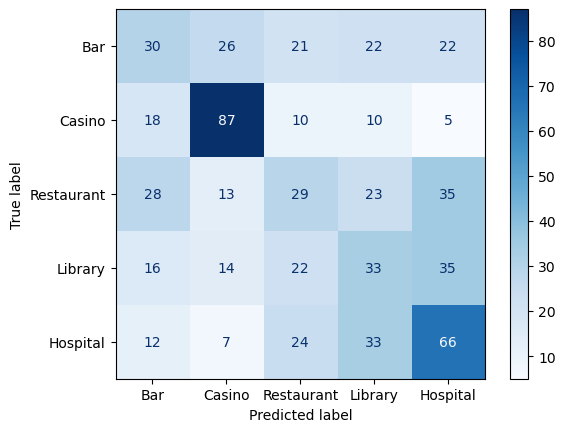

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes).plot(cmap=plt.cm.Blues)
plt.show()